In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import datetime
%config InlineBackend.figure_format = 'retina'

In [2]:
age_details = pd.read_csv('AgeGroupDetails.csv')
covid_india = pd.read_csv('covid_19_india.csv')
hospital_beds = pd.read_csv('HospitalBedsIndia.csv')
icmr_testing = pd.read_csv('ICMRTestingDetails.csv', sep='\t')
individual_details = pd.read_csv('IndividualDetails.csv')
census = pd.read_csv('population_india_census2011.csv')


In [3]:
individual_details

,id,government_id,diagnosed_date,age,gender,detected_city,detected_district,detected_state,nationality,status_change_date,notes
0,0,KL-TS-P1,30/01/2020,20,F,Thrissur,Thrissur,Kerala,India,14/02/2020,Travelled from Wuhan
1,1,KL-AL-P1,02/02/2020,NaN,NaN,Alappuzha,Alappuzha,Kerala,India,14/02/2020,Travelled from Wuhan
2,2,KL-KS-P1,03/02/2020,NaN,NaN,Kasaragod,Kasaragod,Kerala,India,14/02/2020,Travelled from Wuhan
3,3,DL-P1,02/03/2020,45,M,East Delhi (Mayur Vihar),East Delhi,Delhi,India,15/03/2020,"Travelled from Austria, Italy"
4,4,TS-P1,02/03/2020,24,M,Hyderabad,Hyderabad,Telangana,India,02/03/2020,"Travelled from Dubai to Bangalore on 20th Feb,..."
...,...,...,...,...,...,...,...,...,...,...,...
13659,13660,KA-P349,17/04/2020,NaN,NaN,NaN,Bengaluru,Karnataka,NaN,17/04/2020,NaN
13660,13661,KA-P350,17/04/2020,NaN,NaN,NaN,Bengaluru,Karnataka,NaN,17/04/2020,NaN
13661,13662,KA-P351,17/04/2020,NaN,NaN,NaN,Bengaluru,Karnataka,NaN,17/04/2020,NaN
13662,13663,KA-P352,17/04/2020,NaN,NaN,NaN,Bengaluru,Karnataka,NaN,17/04/2020,NaN


In [4]:
covid_india.rename(columns = {'State/UnionTerritory':'State'}, inplace=True)
census.rename(columns = {'State / Union Territory':'State'}, inplace=True)


##  Which age group is most affected?


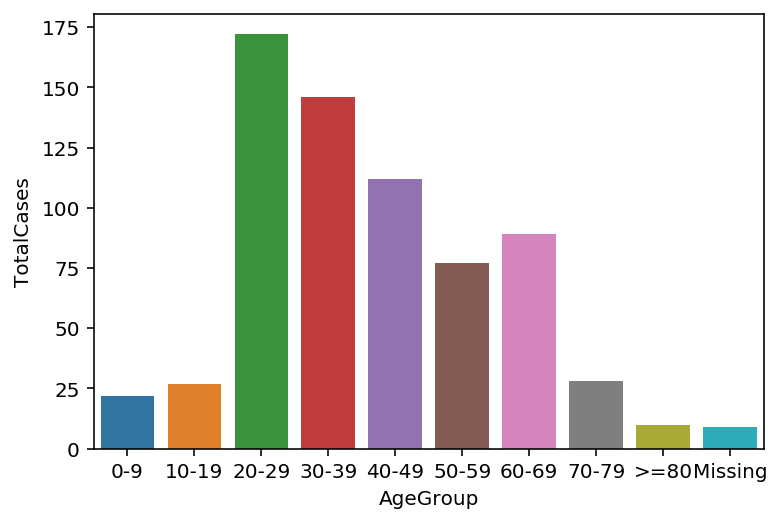

In [5]:
sns.barplot(x = 'AgeGroup', y='TotalCases', data = age_details)


**The 20-29 age group has the most number of cases, followed by the 30-39 age group**

## Graphs of the cases observed, recovered and deaths per day in the country and statewise.

**Let's define the number of active cases as (confirmed - deaths - cured)**

In [6]:
covid_india['Active'] = covid_india.Confirmed - covid_india.Cured - covid_india.Deaths

In [7]:
covid_india['Date'] = pd.to_datetime(covid_india.Date, dayfirst=True) 

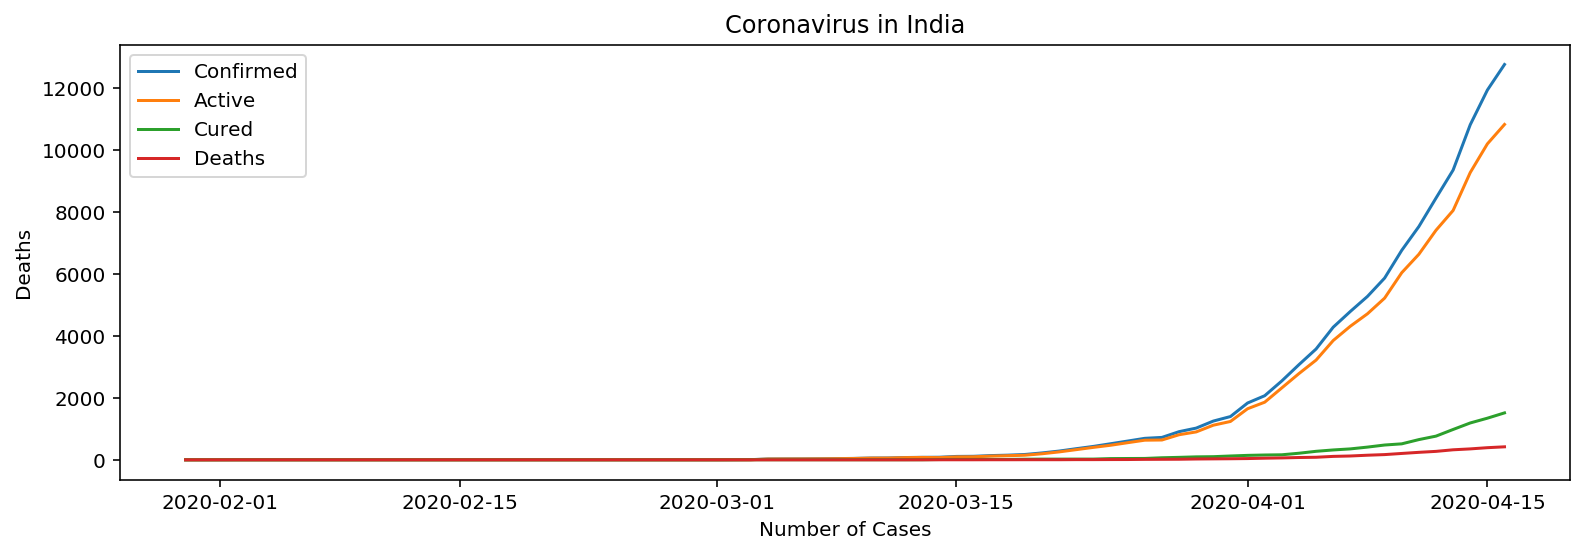

In [8]:
plt.figure(figsize=(13,4))
sns.lineplot(x = covid_india.groupby('Date').sum().index, y = covid_india.groupby('Date').sum().Confirmed)
sns.lineplot(x = covid_india.groupby('Date').sum().index, y = covid_india.groupby('Date').sum().Active)
sns.lineplot(x = covid_india.groupby('Date').sum().index, y = covid_india.groupby('Date').sum().Cured)
sns.lineplot(x = covid_india.groupby('Date').sum().index, y = covid_india.groupby('Date').sum().Deaths)
plt.xlabel('Number of Cases')
plt.title('Coronavirus in India')
plt.legend(['Confirmed','Active','Cured','Deaths'])

(array([737456., 737470., 737485., 737499., 737516., 737530.]),
 <a list of 6 Text xticklabel objects>)

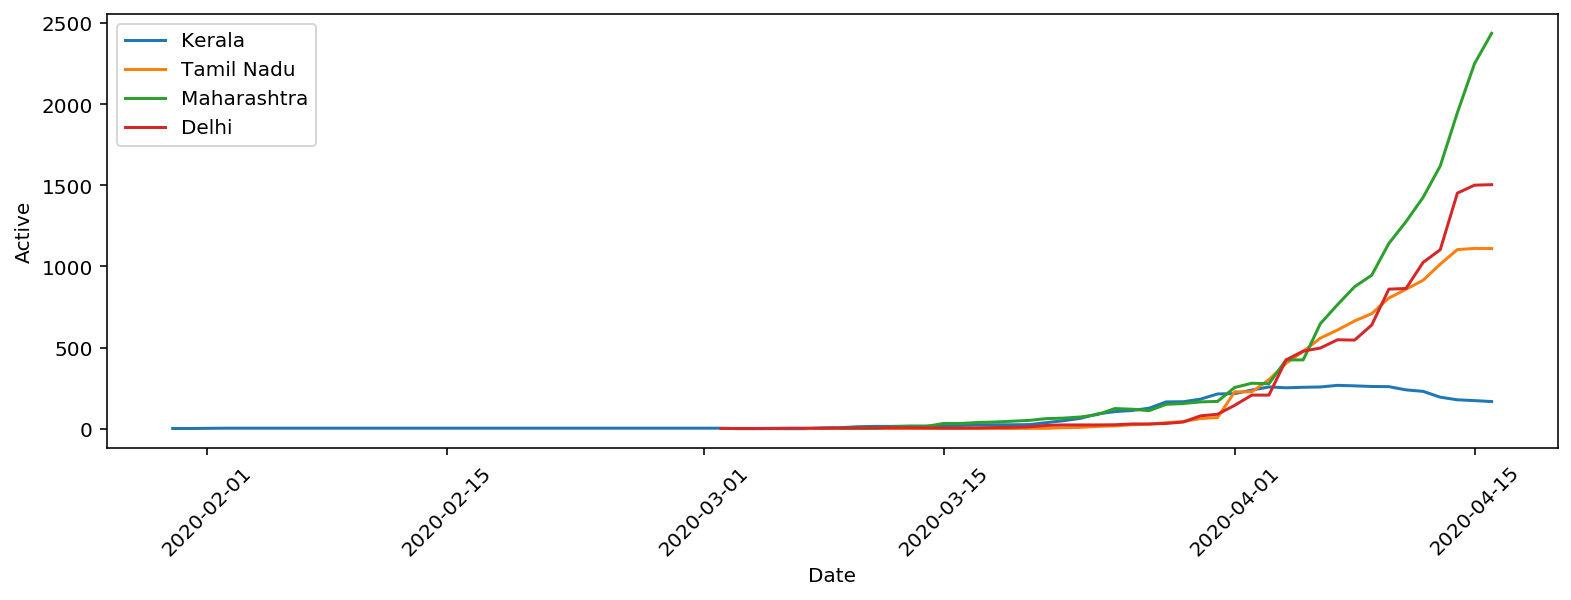

In [9]:
plt.figure(figsize = (13,4))
states_to_plot = ['Kerala','Tamil Nadu','Maharashtra', 'Delhi']
for state in states_to_plot:
    sns.lineplot(x = covid_india[covid_india['State']==state].Date, y = covid_india[covid_india['State']==state].Active)
plt.legend(states_to_plot)
plt.xticks(rotation=45)

## Intensity of virus spread in each state

In [10]:
state_wise = covid_india.groupby('State').sum().drop(columns = 'Sno').reset_index()

Population density is stored in a screwed up format in the 'census' table. Use regular expressions to fix the format

In [11]:
def extract_density(string):
    result = re.search('^([\d,\.]+)/km2', string)
    if result:
        density = re.sub(',','',result.group(1))
    return float(density)

In [12]:
census['Density_fixed'] = census.Density.map(extract_density)

In [13]:
state_wise = state_wise[state_wise['State'] != 'Nagaland#'] #clean up some values
state_wise = state_wise[state_wise['State'] != 'Unassigned']

In [14]:
state_wise['Intensity'] = state_wise['State'].map(lambda x: float(state_wise.loc[state_wise['State']==x].Confirmed) / float(census.loc[census['State'] == x].Density_fixed))

Remove Ladakh's intensity, since it is an outlier (very low population density)

In [15]:
state_wise.loc[state_wise.State =='Ladakh', 'Intensity'] = 0

Text(0.5, 1.0, 'Number of confirmed cases per state (as of 16th April)')

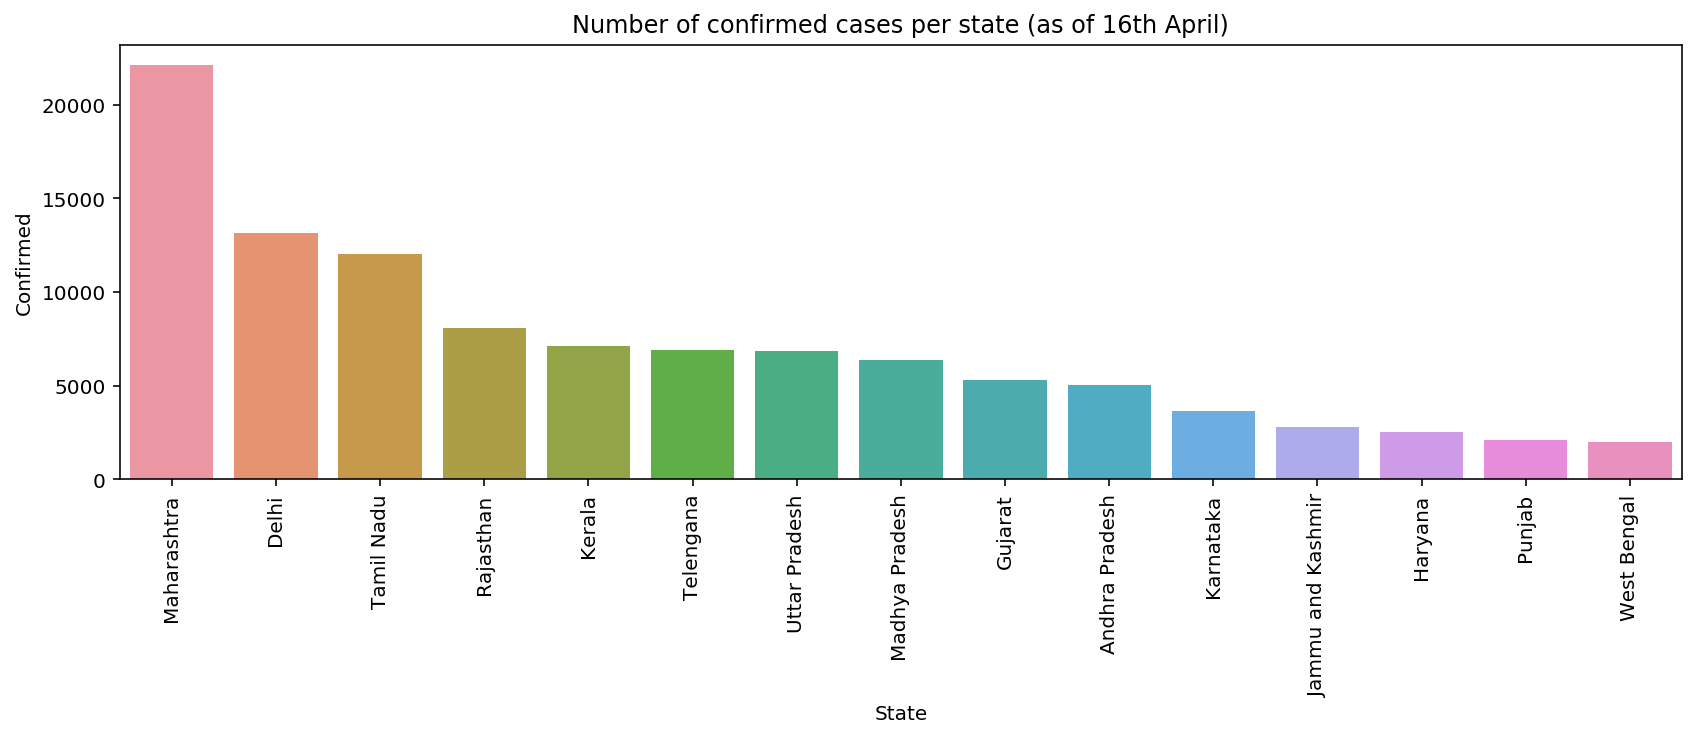

In [16]:
plt.figure(figsize=(14,4))
sns.barplot(x='State',y='Confirmed',data=state_wise[state_wise.Confirmed > 1000].sort_values(by='Confirmed', ascending=False))
plt.xticks(rotation = 90)
plt.title('Number of confirmed cases per state (as of 16th April)')

Text(0.5, 1.0, 'Intensity of virus spread in each state (as of 16th April)')

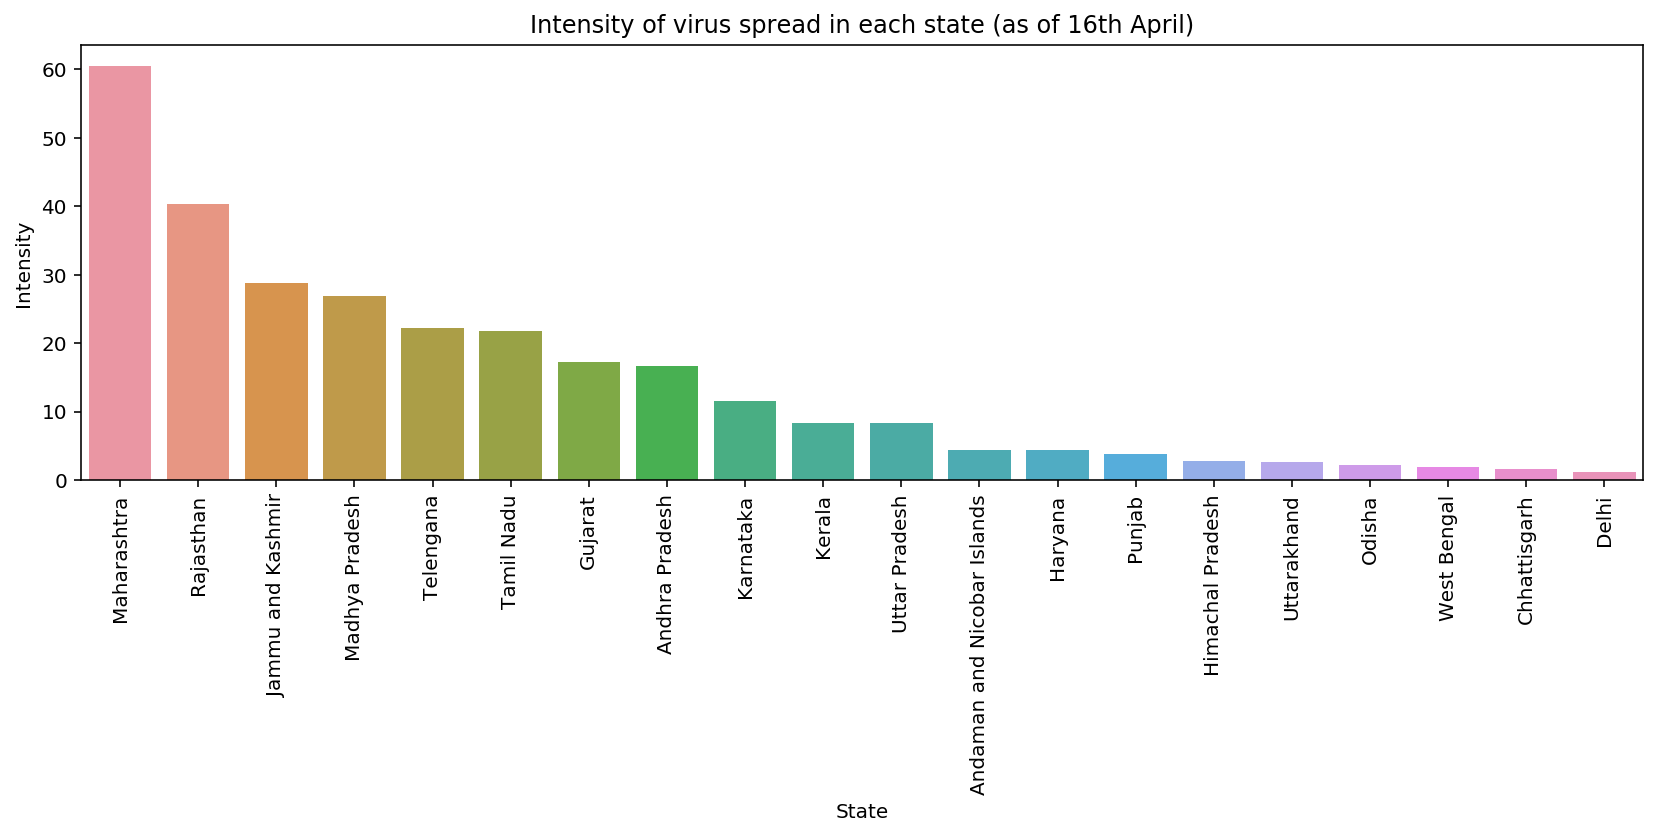

In [17]:
plt.figure(figsize=(14,4))
sns.barplot(x='State',y='Intensity',data=state_wise.sort_values(by='Intensity', ascending=False)[:20])
plt.xticks(rotation = 90)
plt.title('Intensity of virus spread in each state (as of 16th April)')

## Identifying hotspots in the country
A hotspot is defined as an area or city where 10 of more people have been tested positive.

In [18]:
individual_details.diagnosed_date = pd.to_datetime(individual_details.diagnosed_date, dayfirst=True)


In [19]:
def find_hotspots(df):
    city_cases = df.detected_city.value_counts()
    hotspots = [key for key, cases in zip(city_cases.keys(), city_cases.values) if cases>=10]
    state_of_hotspot = []
    for hotspot in hotspots:
        state_of_hotspot.append(df[df.detected_city == hotspot].detected_state.unique().item())
    states_with_hotspots, count = np.unique(state_of_hotspot, return_counts=True)
    out_df = pd.DataFrame({'Count': count}, index = states_with_hotspots).sort_values(by = 'Count',ascending=False)
    
    return hotspots, out_df

In [20]:
_, hotspots_before = find_hotspots(individual_details[individual_details.diagnosed_date <= '2020-03-20'])
hotspots, hotspots_after = find_hotspots(individual_details[individual_details.diagnosed_date <= '2020-04-10'])

Hotspots identified as of 10th April: 

*Mumbai, Bengaluru, Kalyan-Dombivali, Navi Mumbai, Kasaragod, Nizamuddin area, Hyderabad, Pimpri-Chinchwad, Mira-Bhayandar, Mettupalayam, Bhubaneswar, Bhilwara, Ongole, Ahmednagar, Gurugram, Perundurai, Ahmedabad, Pune, Kurnool, Ramganj, Bodi, Noida, Mohali, Vijayawada*


In [21]:
print(hotspots)


['Mumbai', 'Bengaluru', 'Kalyan-Dombivali', 'Navi Mumbai', 'Kasaragod', 'Nizamuddin area', 'Hyderabad', 'Pimpri-Chinchwad', 'Mira-Bhayandar', 'Mettupalayam', 'Bhubaneswar', 'Bhilwara', 'Ongole', 'Ahmednagar', 'Ahmedabad', 'Gurugram', 'Perundurai', 'Pune', 'Kurnool', 'Ramganj', 'Bodi', 'Noida', 'Mohali', 'Vijayawada']


Number of hotspots per state compared between the two dates:

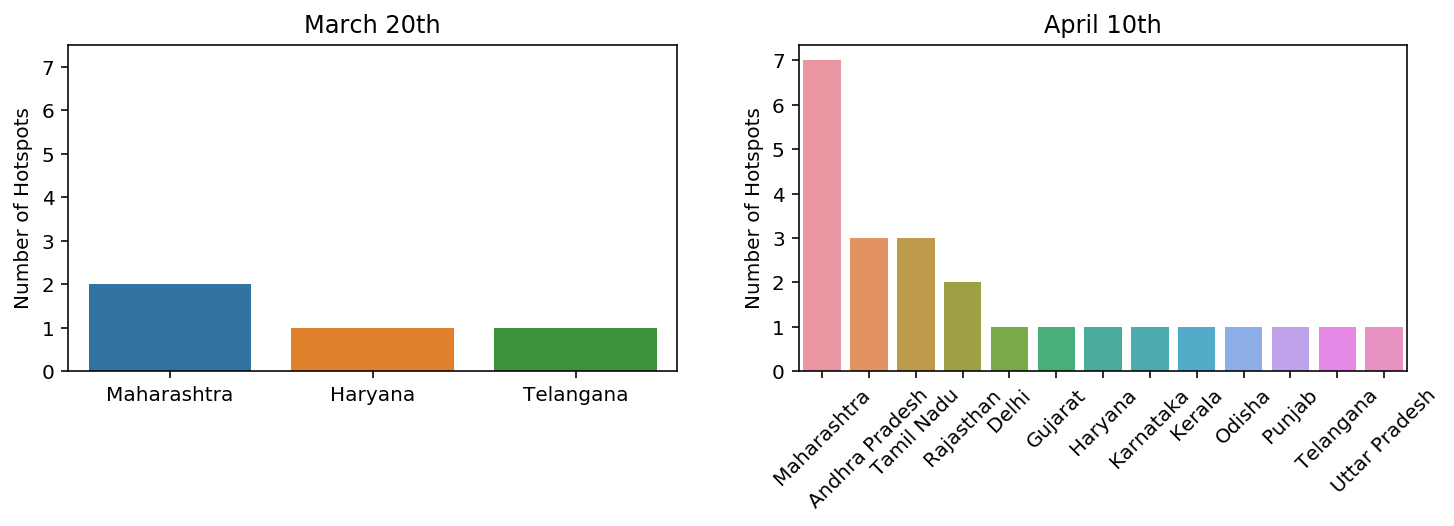

In [22]:
fig, ax = plt.subplots(1,2, figsize=(12,3))
sns.barplot(y = hotspots_before.Count, x = hotspots_before.index, ax = ax[0])
sns.barplot(y = hotspots_after.Count, x = hotspots_after.index, ax = ax[1])
ax[0].set_title('March 20th')
ax[0].set_ylabel('Number of Hotspots')
ax[0].set_ylim(0,7.5)
ax[1].set_title('April 10th')
ax[1].set_ylabel('Number of Hotspots')
g = plt.xticks(rotation=45)

## Type of transmission

* Primary case: International travel history
* Secondary case: Contact with primary case
* Tertiary case: Neither primary nor secondary

In [23]:
individual_details.notes.value_counts()


Details awaited                                      9354
Travelled to Delhi                                    863
Details Awaited                                       377
Travelled from Dubai                                   98
Local Transmission                                     92
                                                     ... 
Father of P43                                           1
Guide to Indonesian Tourist; Resident of Chennai        1
Patient is from Punjab but admitted in Chandigarh       1
Contact of KA-P164                                      1
Travelled from Netherlands March 9                      1
Name: notes, Length: 775, dtype: int64

Many cases are 'details awaited'. We shall remove these datapoints

In [24]:
individual_details = individual_details[~individual_details.notes.str.contains('[dD]etails [aA]waited', regex=True).fillna(False)]

### Primary cases:

The description of most primary cases will have the word **Travelled** along with the name of a **city or country outside India**

Example: Travelled from Italy

We will use a dataset of names of cities and countries around the world (https://simplemaps.com/data/world-cities), and filter out names of all the cities and countries outside of India. Then we will use this to search through our data for primary cases.

In [25]:
world_cities = pd.read_csv('worldcities.csv')
world_cities.head()


,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6850,139.7514,Japan,JP,JPN,Tōkyō,primary,35676000.0,1392685764
1,New York,New York,40.6943,-73.9249,United States,US,USA,New York,NaN,19354922.0,1840034016
2,Mexico City,Mexico City,19.4424,-99.1310,Mexico,MX,MEX,Ciudad de México,primary,19028000.0,1484247881
3,Mumbai,Mumbai,19.0170,72.8570,India,IN,IND,Mahārāshtra,admin,18978000.0,1356226629
4,São Paulo,Sao Paulo,-23.5587,-46.6250,Brazil,BR,BRA,São Paulo,admin,18845000.0,1076532519


The dataset includes the name of a **town in the US named Delhi**, which screws up our search, so we shall remove it.

In [26]:
world_cities = world_cities[~((world_cities.city_ascii.str.contains('Delhi')) & (world_cities.country=='United States'))]

Generate a search string, and use Regular Expressions to extract primary cases.


In [27]:
cities = list(world_cities[world_cities.country!='India'].city_ascii)
countries = list(world_cities[world_cities.country!='India'].country)
primary_keywords = '|'.join(cities + countries)

In [28]:
primary = individual_details[((individual_details.notes.str.contains(primary_keywords, regex=True)) & (individual_details.notes.str.contains('Travel'))).fillna(False)]

/Users/abhiramtarimala/my_python_env/lib/python3.7/site-packages/pandas/core/strings.py:1952: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [29]:
primary.notes.shape

(491,)

501 primary cases identified!

Remove primary cases from data, so that it doesn't interfere with search for secondary cases

In [30]:
individual_details = individual_details[~individual_details.notes.isin(primary.notes)]


### Secondary cases: 
Search for relationship keywords

In [31]:
sec_keywords = '[Dd]aughter|[Ff]ather|[Ss]on|[Ww]ife|[Ff]riend|[uU]ncle|[bB]rother|[nN]eighbour|[rR]elative' #case sensitive!

In [32]:
secondary = individual_details[(individual_details.notes.str.contains(sec_keywords, regex=True)).fillna(False)] #search

In [33]:
secondary.notes.shape


(168,)

183 secondary cases identified!

### Tertiary cases:

We can assume that the other cases are tertiary cases.

However, this analysis is quite approximate. There are many cases where the description is ambiguous, for example, majority of the non-primary cases have 'Travelled to Delhi'. These cases could either be secondary or tertiary depending on who the person contracted the virus from, and cannot be determined without more information. Further, the descriptions have been written without any coherent structure. 

## Number of Additional Labs Required

In [58]:
icmr_testing = pd.read_csv('ICMRTestingDetails.csv')

In [59]:
#Calculating the Ratio to Find Number of Required Samples per Person  
# Positive Cases : Test Cases 
samplespp = icmr_testing.dropna(subset = ['TotalSamplesTested','TotalIndividualsTested'])
samplespp['Ratio'] = samplespp['TotalSamplesTested']/samplespp['TotalIndividualsTested']

samplespp['Ratio'].min(),samplespp['Ratio'].mean(),samplespp['Ratio'].max()

/Users/abhiramtarimala/my_python_env/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


(1.0366949781479344, 1.0686427306013853, 1.1079423817970517)

I have chosen to take the maximum value of the ratio - this is to allow for a buffer number of tests if required.
Number of Samples/Number of Indiviuals = 1.1079423817970517

In [60]:
testspercase = icmr_testing.dropna(subset = ['TotalPositiveCases','TotalIndividualsTested'])
testspercase['Ratio'] = testspercase['TotalIndividualsTested']/testspercase['TotalPositiveCases']

/Users/abhiramtarimala/my_python_env/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [61]:
testspercase

,SNo,DateTime,TotalSamplesTested,TotalIndividualsTested,TotalPositiveCases,Source,Ratio
0,1,13/03/20 18:00,6500.0,5900.0,78.0,Press_Release_ICMR_13March2020.pdf,75.641026
1,2,18/03/20 18:00,13125.0,12235.0,150.0,ICMR_website_update_18March_6PM_IST.pdf,81.566667
2,3,19/03/20 18:00,14175.0,13285.0,182.0,ICMR_website_update_19March_6PM_IST.pdf,72.994505
3,4,20/03/20 18:00,15404.0,14514.0,236.0,ICMR_website_update_20March_6PM_IST.pdf,61.500000
4,5,21/03/20 18:00,16911.0,16021.0,315.0,ICMR_website_update_21March_6PM_IST.pdf,50.860317
5,6,22/03/20 18:00,18127.0,17237.0,396.0,ICMR_website_update_22March_6PM_IST.pdf,43.527778
6,7,23/03/20 20:00,20707.0,19817.0,471.0,ICMR_website_update_23March_8PM_IST.pdf,42.074310
7,8,24/03/20 20:00,22694.0,21804.0,536.0,ICMR_website_update_24March_8PM_IST.pdf,40.679104
8,9,25/03/20 20:00,25144.0,24254.0,581.0,ICMR_website_update_25March_8PM_IST.pdf,41.745267
23,24,09/04/20 21:00,144910.0,130792.0,5705.0,NaN,22.925855


We can see that as time progresses, the people who are tested are more likely to have the virus ( the ratio reduces from 75.641026 on 13/03/20 to 22.789444 on 16/04/20. 


The reason for this is that a lot of unnecessary tests were done initially as all the people who returned from international trips were tested and most of those cases would prove to be negative. 

As the situation stabilised and the lockdown is enforced, the number of unnecessary tests reduces and the ratio of tests to positive cases stabilises at around 22. 

In [62]:
icmr_labs = pd.read_csv('ICMRTestingLabs.csv')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 <a list of 34 Text xticklabel objects>)

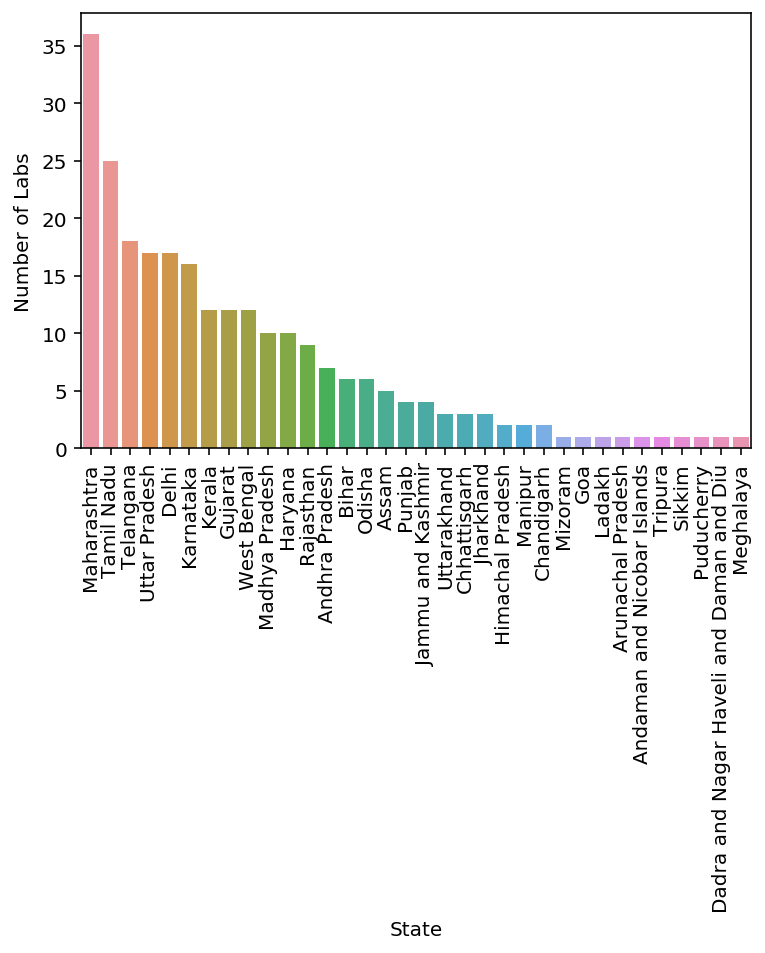

In [63]:
statewise_labs = icmr_labs['state'].value_counts().to_frame(name='Number of Labs').reset_index()
statewise_labs.rename(columns = {'index':'State'}, inplace = True)
sns.barplot(x = 'State', y='Number of Labs', data = statewise_labs)
plt.xticks(rotation=90)

In [64]:
statewise_labs['Capacity'] = statewise_labs['Number of Labs']*100

In [65]:
statewise_labs

,State,Number of Labs,Capacity
0,Maharashtra,36,3600
1,Tamil Nadu,25,2500
2,Telangana,18,1800
3,Uttar Pradesh,17,1700
4,Delhi,17,1700
5,Karnataka,16,1600
6,Kerala,12,1200
7,Gujarat,12,1200
8,West Bengal,12,1200
9,Madhya Pradesh,10,1000


In [66]:
start_date = covid_india[covid_india['Date']=='2020-04-11'].drop_duplicates(subset =['State'], keep = 'last')

In [67]:
Predictions = pd.DataFrame()
Predictions['State'] = start_date['State']
Predictions['11-04'] = start_date['Active']

for i in range(1,10):
    string0 = str(10+i)+'-04'
    string = str(11+i)+'-04'
    Predictions[string] = Predictions[string0]*1.1

In [68]:
Predictions.loc[:,'11-04':'20-04'] = Predictions.loc[:,'11-04':'20-04'].astype(int)

The maximum number of new cases would be on the last day. Assuming we need test all the new cases that come up in a state on a particular day on the same day, we need as many labs as are required to test the mumber of cases on the last day.

In [69]:
Predictions['Max'] = (Predictions['20-04']-Predictions['19-04']) + 1
Predictions['Number of People to Test'] = Predictions['Max']*23
Predictions['Number of Tests Required'] = (Predictions['Number of People to Test']*1.10).astype(int)

In [70]:
Predictions = Predictions.merge(statewise_labs, left_on = 'State', right_on = 'State', how = 'left')

In [95]:
Predictions['Deficit'] = Predictions['Number of Tests Required']-Predictions['Capacity']

In [100]:
Predictions['Excess Labs'] = (Predictions['Deficit']/100).astype(int)+1

In [101]:
Predictions.loc[Predictions['Excess Labs']<0, 'Excess Labs'] = 0

In [102]:
Predictions.dropna(subset=['Number of Labs'], inplace = True)

In [103]:
Predictions

,State,11-04,12-04,13-04,14-04,15-04,16-04,17-04,18-04,19-04,20-04,Max,Number of People to Test,Number of Tests Required,Number of Labs,Capacity,Deficit,Excess Labs
0,Andhra Pradesh,364,400,440,484,532,586,644,709,780,858,79,1817,1998,7.0,700.0,1298.0,13
1,Andaman and Nicobar Islands,11,12,13,14,16,17,19,21,23,25,3,69,75,1.0,100.0,-25.0,1
2,Arunachal Pradesh,1,1,1,1,1,1,1,1,2,2,1,23,25,1.0,100.0,-75.0,1
3,Assam,28,30,33,37,40,45,49,54,60,66,7,161,177,5.0,500.0,-323.0,0
4,Bihar,59,64,71,78,86,95,104,114,126,139,14,322,354,6.0,600.0,-246.0,0
5,Chandigarh,11,12,13,14,16,17,19,21,23,25,3,69,75,2.0,200.0,-125.0,0
6,Chhattisgarh,9,9,10,11,13,14,15,17,19,21,3,69,75,3.0,300.0,-225.0,0
7,Delhi,864,950,1045,1149,1264,1391,1530,1683,1852,2037,186,4278,4705,17.0,1700.0,3005.0,31
8,Goa,6,6,7,7,8,9,10,11,12,14,3,69,75,1.0,100.0,-25.0,1
9,Gujarat,258,283,312,343,377,415,457,502,553,608,56,1288,1416,12.0,1200.0,216.0,3


In [104]:
Predictions.to_excel('Labs.xlsx')

In [105]:
Predictions['Excess Labs'].sum()

162

In [106]:
int((Predictions['Number of Tests Required'].sum()-Predictions['Capacity'].sum())/100)

112

## Has the lockdown been successful?

Text(0.5, 1.0, 'Number of cases in India between March 1 and April 10')

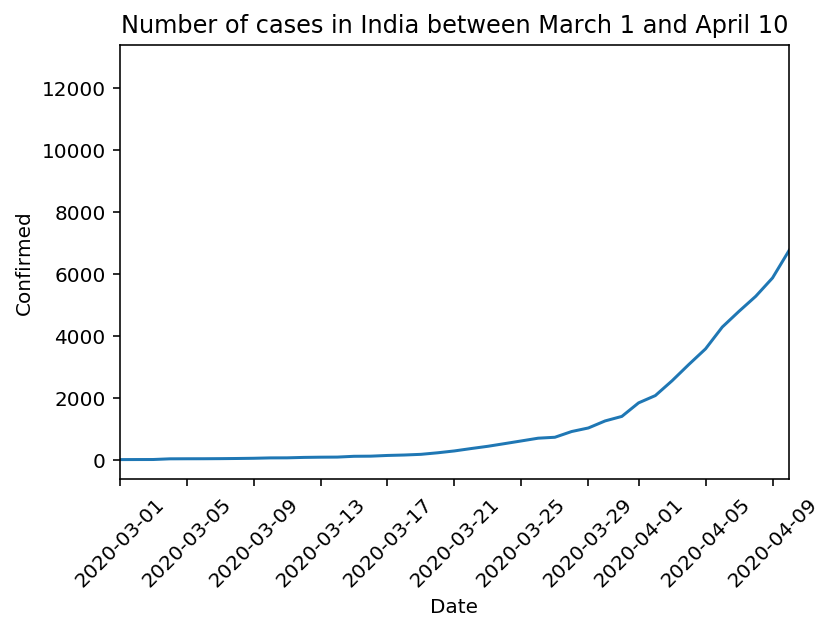

In [37]:
sns.lineplot(x = covid_india.groupby('Date').sum().index, y = covid_india.groupby('Date').sum().Confirmed)
plt.xlim(datetime.date(2020,3,1),datetime.date(2020,4,10))
g=plt.xticks(rotation=45)
plt.title('Number of cases in India between March 1 and April 10')

In the above graph, the lockdown which started on 25th March doesn't seem to have had any positive effect in slowing down the virus spread. **However**, it is important to note that the notion of 'flattening the curve' is only valid when comparing the curves in the cases where there is a lockdown and where there isn't a lockdown (a hypothetical case). 

As a rough estimate of the curve in the case where there is no lockdown, we shall use the curve of the United States, the country worst hit by the pandemic, and a country which doesn't have any widespread lockdown in place.

https://www.kaggle.com/imdevskp/corona-virus-report#covid_19_clean_complete.csv

In [34]:
covid_world = pd.read_csv('covid_19_clean_complete.csv', parse_dates=['Date'])
covid_world.drop(columns = ['Province/State'], inplace=True)
covid_usa = covid_world[covid_world['Country/Region']=='US']

In [35]:
scale=30
offset=9 #days

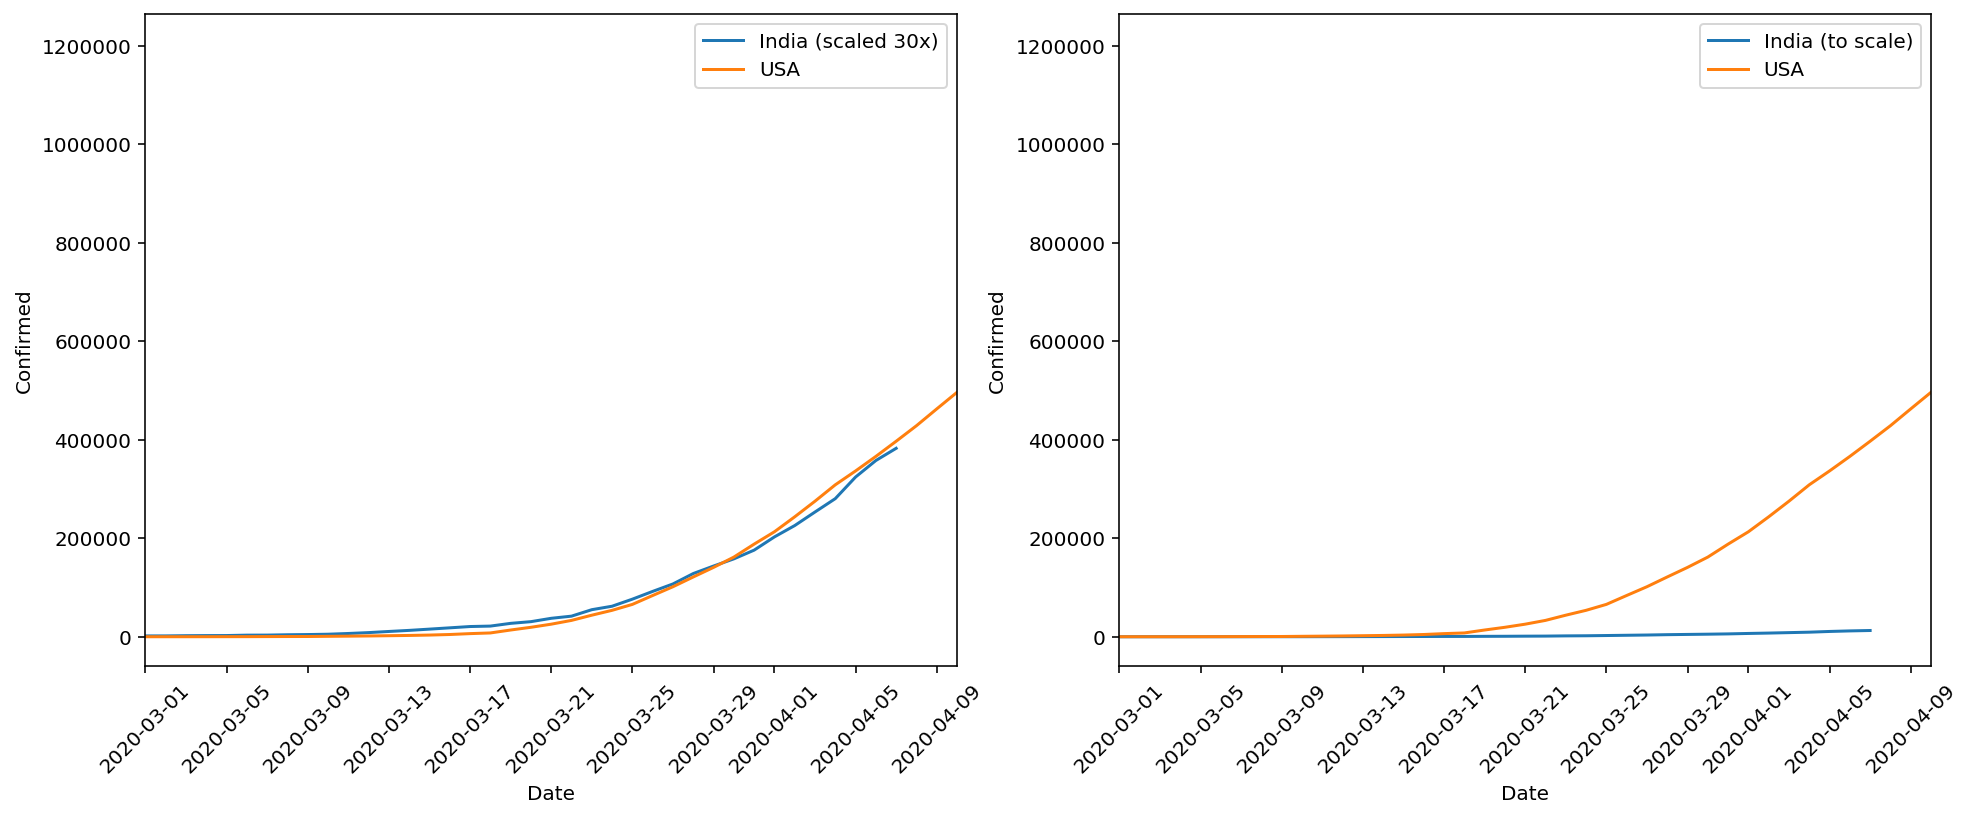

In [36]:
fig, ax = plt.subplots(1,2, figsize=(16,6))

sns.lineplot(x = (covid_india.groupby('Date').sum().index - pd.DateOffset(days=offset)), y = scale*covid_india.groupby('Date').sum().Confirmed, ax=ax[0])
sns.lineplot(x='Date',y='Confirmed',data=covid_usa, ax=ax[0])
ax[0].set_xlim(datetime.date(2020,3,1),datetime.date(2020,4,10))
ax[0].legend(['India (scaled 30x)','USA'])

sns.lineplot(x = (covid_india.groupby('Date').sum().index - pd.DateOffset(days=offset)), y = covid_india.groupby('Date').sum().Confirmed, ax=ax[1])
sns.lineplot(x='Date',y='Confirmed',data=covid_usa, ax=ax[1])
ax[1].set_xlim(datetime.date(2020,3,1),datetime.date(2020,4,10))
ax[1].legend(['India (to scale)','USA'])

for tick in ax[0].get_xticklabels():
    tick.set_rotation(45)
for tick in ax[1].get_xticklabels():
    tick.set_rotation(45)

In the above graphs, **the x-axis for the India curve has been shifted** by 9 days so that the curves can be compared.

When the number of cases in India is **scaled by a factor of 30**, the curves seem to coincide! 

So the growth in India is around 30 times less than the growth in the US. This **may be attributed** to the 21-day lockdown, but is **also dependent** on several other factors such as testing rates, hotter climate, etc.